In [2]:
# Entrando no drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [132]:
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline 
import numpy as np
import pandas as pd
import os
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose
import xlrd
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [4]:
# Importing all climate data
DATA_PATH = '/content/drive/MyDrive/TCC/Programa/Energy_consumption_forecasting/data/treated/csv'

df_humid_1h = pd.read_csv(os.path.join(DATA_PATH, 'humidity.csv'), index_col='date', parse_dates = ['date'])
df_pres_1h = pd.read_csv(os.path.join(DATA_PATH, 'pressure.csv'), index_col='date', parse_dates = ['date'])
df_rad_1d = pd.read_csv(os.path.join(DATA_PATH, 'radiation.csv'), index_col='date', parse_dates = ['date'])
df_wind_1h = pd.read_csv(os.path.join(DATA_PATH, 'wind.csv'), index_col='date', parse_dates = ['date'])
df_wet_temp_1h = pd.read_csv(os.path.join(DATA_PATH, 'wet_temperature.csv'), index_col='date', parse_dates = ['date'])
df_dry_temp_1h = pd.read_csv(os.path.join(DATA_PATH, 'dry_temperature.csv'), index_col='date', parse_dates = ['date'])
df_electric_15m = pd.read_csv(os.path.join(DATA_PATH, 'electric_consumption.csv'), index_col='date', parse_dates = ['date'])


# Tratando os dados de consumo

Start date:  2006-01-13 09:45:00
End date:    2007-12-05 13:30:00


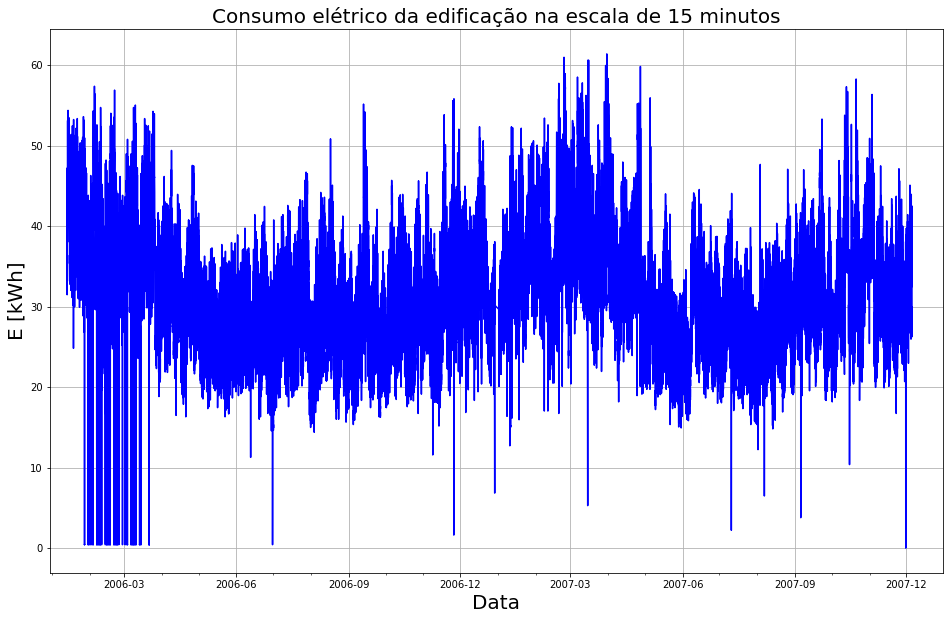

In [5]:
# Plotando o consumo elétrico da edificação
start_date = df_electric_15m.index.min()
end_date = df_electric_15m.index.max()

# Setting the plot
print("Start date: ", start_date)
print("End date:   ", end_date)

fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(df_electric_15m.index, df_electric_15m['ep_kwh'], color='blue')
ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo elétrico da edificação na escala de 15 minutos", fontsize=20)

ax.grid(True)
plt.show()

Count of trimmed values:  547


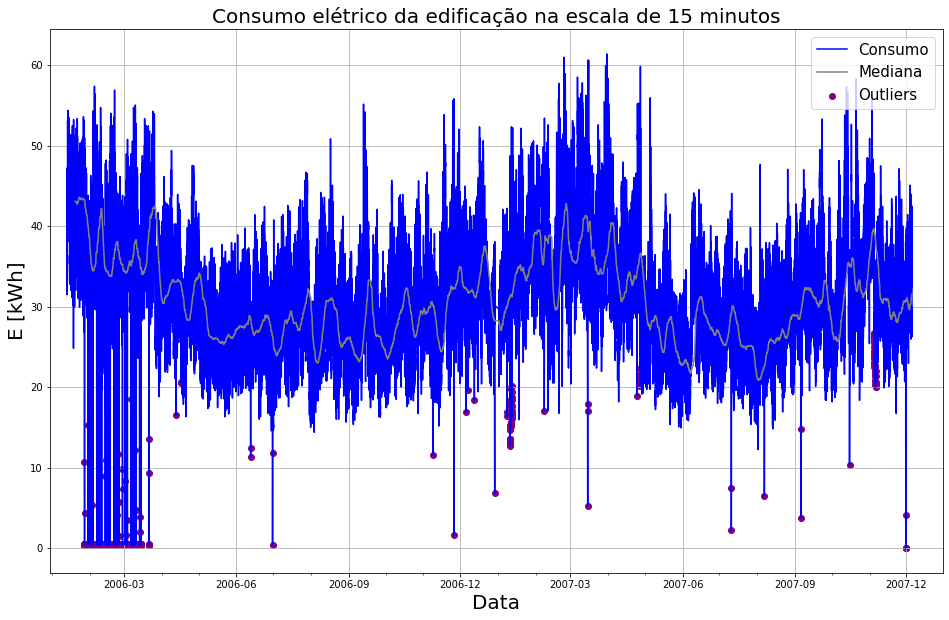

In [6]:
# Identifying outliers on the data 
# Applying a rolling window and getting the median
days = 7
window = (60//15)*24*days # Rolling window of 12 hours
amp_threshold = 7
min_threshhold = 7


roll = df_electric_15m['ep_kwh'].rolling(window)

# Applying an running MAD: median absolute deviation from the median.
# This is a strongly robust measure of variation within the data, akin to a standard deviation.
# An outlying peak would be several MADs or more greater than the median.
df_electric_15m['median'] = roll.median()
# df_electric_15m['upper_bound'] = roll.median() + 2*amp_threshold * ((df_electric_15m['ep_kwh'] - df_electric_15m['median']).abs()).median()
# df_electric_15m['lower_bound'] = roll.median() - amp_threshold * ((df_electric_15m['ep_kwh'] - df_electric_15m['median']).abs()).median()

# Trimming outliers by the normal curve
df_electric_15m['mean'] = roll.mean()
# df_electric_15m['upper_bound'] = roll.mean() + 4*((df_electric_15m['ep_kwh'] - df_electric_15m['mean'])).std()
# df_electric_15m['lower_bound'] = roll.mean() - 2*((df_electric_15m['ep_kwh'] - df_electric_15m['mean'])).std()

# Trimming outliers by quantile
Q1 = roll.quantile(0.25)
Q3 = roll.quantile(0.75)
IQR = Q3 - Q1

df_electric_15m['upper_bound'] = Q3 + 1.5*IQR
df_electric_15m['lower_bound'] = Q1 - 1.5*IQR

#mask_outliers = ((df_electric_15m['ep_kwh'] > df_electric_15m['upper_bound']) |
#                 (df_electric_15m['ep_kwh'] < df_electric_15m['lower_bound']) |
#                 (df_electric_15m['ep_kwh'] < min_threshhold))

mask_outliers = ((df_electric_15m['ep_kwh'] < df_electric_15m['lower_bound']) |
                (df_electric_15m['ep_kwh'] < min_threshhold))

print("Count of trimmed values: ", mask_outliers.sum())

# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
#ax.plot(df_electric_15m.index, df_electric_15m['lower_bound'], label='Lower')
#ax.plot(df_electric_15m.index, df_electric_15m['upper_bound'], label='Upper')
ax.plot(df_electric_15m.index, df_electric_15m['ep_kwh'], color='blue', label='Consumo')
ax.plot(df_electric_15m.index, df_electric_15m['median'], color='grey', label='Mediana')
# ax.plot(df_electric_15m.index, df_electric_15m['mean'], color='grey', label='Mean')
ax.scatter(df_electric_15m.loc[mask_outliers].index, df_electric_15m.loc[mask_outliers,'ep_kwh'], color='purple', label='Outliers')


ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo elétrico da edificação na escala de 15 minutos", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

Minimum value found:  0.36


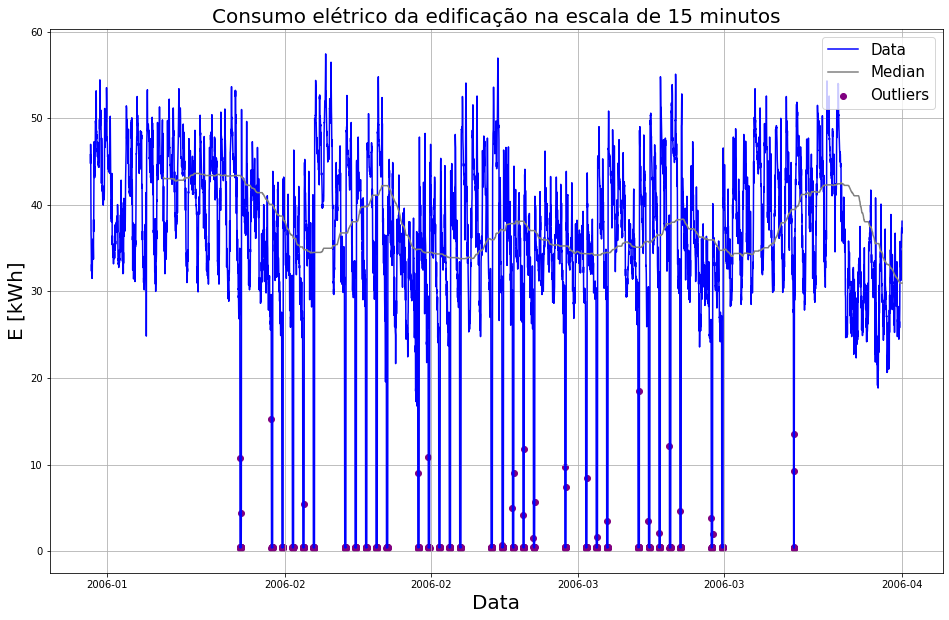

In [7]:
# PLotting a smaller window for visualization
date_interval = df_electric_15m.loc['2006-01':'2006-03']
print("Minimum value found: ", date_interval['ep_kwh'].min())

# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.plot(df_electric_15m.index, df_electric_15m['lower_bound'], label='Lower')
#ax.plot(df_electric_15m.index, df_electric_15m['upper_bound'], label='Upper')
ax.plot(date_interval.index, date_interval['ep_kwh'], color='blue', label='Data')
ax.plot(date_interval.index, date_interval['median'], color='grey', label='Median')
ax.scatter(date_interval.loc[mask_outliers].index, date_interval.loc[mask_outliers,'ep_kwh'], color='purple', label='Outliers')

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo elétrico da edificação na escala de 15 minutos", fontsize=20)
ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

In [14]:
# Defining a Time index
time_15m = pd.date_range(start=start_date, end=end_date, freq="15T", name='date')

df_elec_15m_trim_outliers = df_electric_15m.loc[~mask_outliers]

df_elec_15m_trim_outliers.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65413 entries, 2006-01-13 09:45:00 to 2007-12-05 13:30:00
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   demand_replacement  65413 non-null  int64  
 1   reactive_delay      65413 non-null  int64  
 2   station             65413 non-null  object 
 3   ep_kwh              65413 non-null  float64
 4   eq_kvarh            65413 non-null  float64
 5   p_kw                65413 non-null  float64
 6   q_kvar              65413 non-null  float64
 7   s_kva               65413 non-null  float64
 8   fp                  65413 non-null  float64
 9   fph                 65413 non-null  float64
 10  corr_kvar           65413 non-null  float64
 11  corrh_kvar          65413 non-null  float64
 12  median              64742 non-null  float64
 13  mean                64742 non-null  float64
 14  upper_bound         64742 non-null  float64
 15  lower_bound       

In [15]:
df_elec_15m_trim_outliers = df_elec_15m_trim_outliers[['ep_kwh']]

df_elec_15m_trim_outliers = df_elec_15m_trim_outliers.reindex(time_15m)

df_elec_15m_trim_outliers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66352 entries, 2006-01-13 09:45:00 to 2007-12-05 13:30:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ep_kwh  65413 non-null  float64
dtypes: float64(1)
memory usage: 1.0 MB


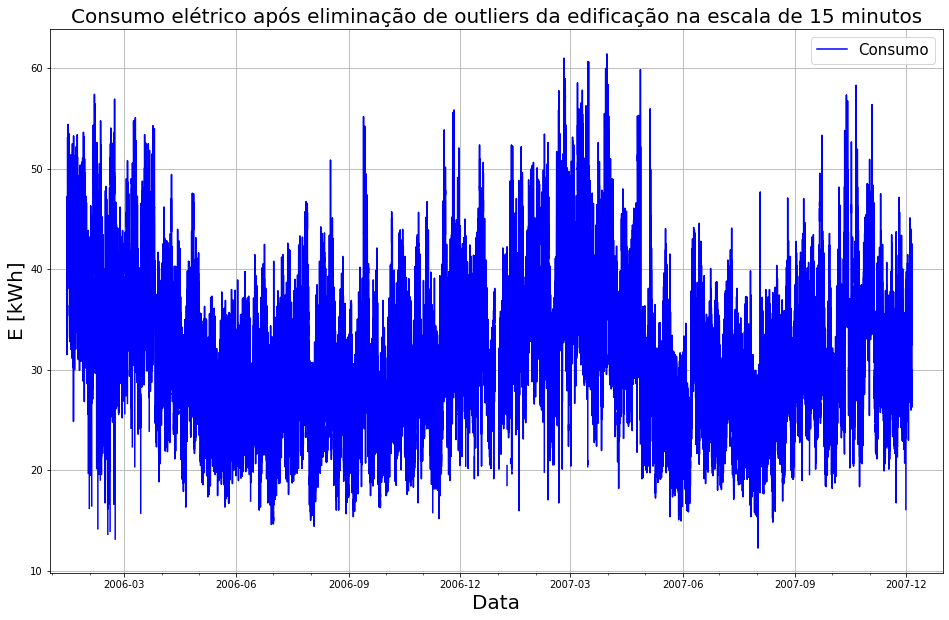

In [16]:
# Plotting the treated consumption
# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(df_elec_15m_trim_outliers.index, df_elec_15m_trim_outliers, color='blue', label='Consumo')

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo elétrico após eliminação de outliers da edificação na escala de 15 minutos", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()


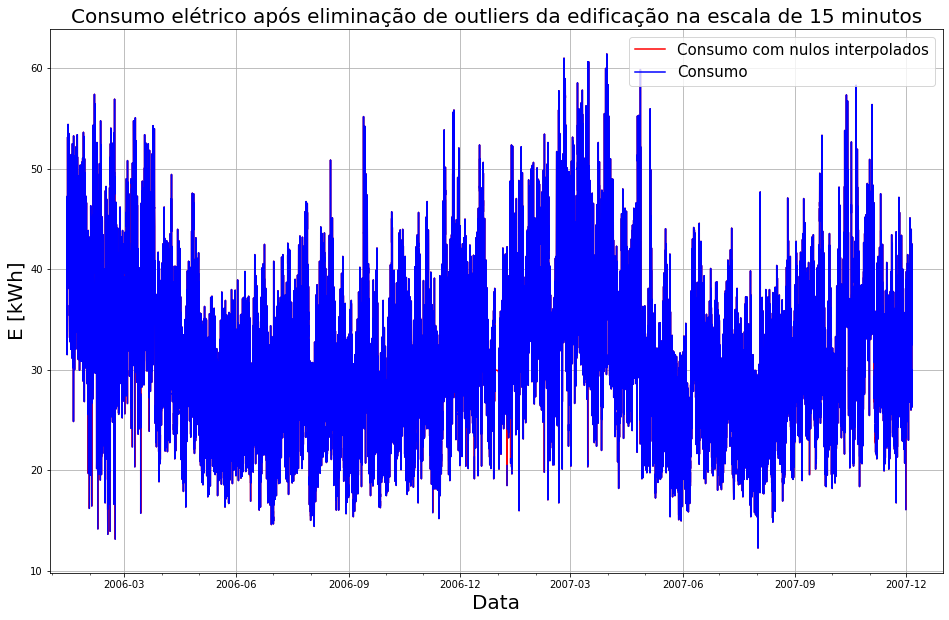

In [37]:
# df_elec_15m_trim_outliers_int = df_elec_15m_trim_outliers.interpolate(method='piecewise_polynomial', order=3)
df_elec_15m_trim_outliers_int = df_elec_15m_trim_outliers.interpolate(method='pchip')


# Plotting the treated consumption
# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=30 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(df_elec_15m_trim_outliers_int.index, df_elec_15m_trim_outliers_int, color='r', label='Consumo com nulos interpolados')
ax.plot(df_elec_15m_trim_outliers.index, df_elec_15m_trim_outliers, color='blue', label='Consumo')

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo elétrico após eliminação de outliers da edificação na escala de 15 minutos", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

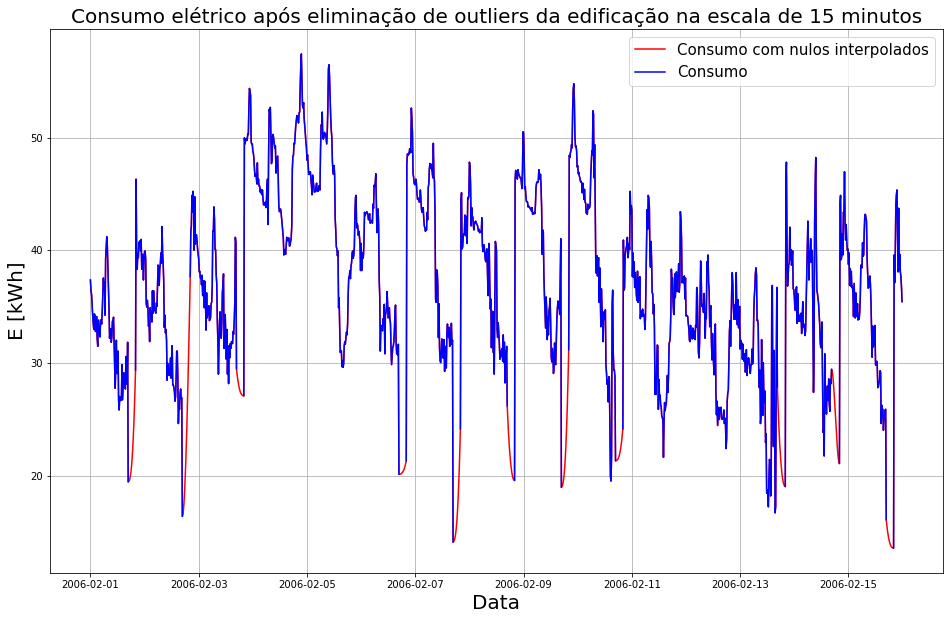

In [38]:
start_filter = '2006-02-01'
end_filter = '2006-02-15'

# Plotting the treated consumption
# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


# Plotting data
ax.plot(df_elec_15m_trim_outliers_int.loc[start_filter:end_filter].index, df_elec_15m_trim_outliers_int.loc[start_filter:end_filter], color='r', label='Consumo com nulos interpolados')
ax.plot(df_elec_15m_trim_outliers.loc[start_filter:end_filter].index, df_elec_15m_trim_outliers.loc[start_filter:end_filter], color='blue', label='Consumo')

ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo elétrico após eliminação de outliers da edificação na escala de 15 minutos", fontsize=20)

ax.legend(fontsize=15, loc='upper right')
ax.grid(True)
plt.show()

# Analisando os dados de consumo

In [98]:
# Resampling to a daily sampling period
df_electric = df_elec_15m_trim_outliers_int['ep_kwh'].resample('D').sum()  # Summing the electricity consumption
df_electric = df_electric.iloc[1:-1] # Excluindo dados do primeiro e último dias

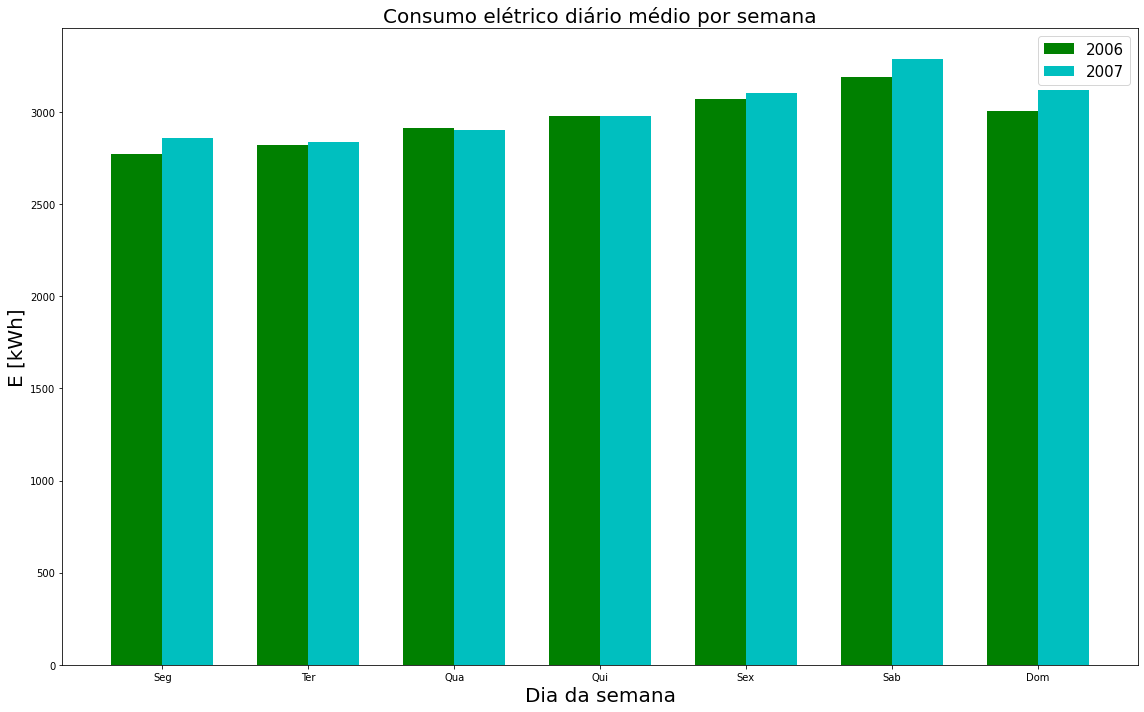

In [99]:
days = ['Seg','Ter','Qua','Qui','Sex','Sab', 'Dom']

data = df_electric.loc['2006']

daily_avg_consumption_2006 = df_electric.loc['2006'].groupby(df_electric.loc['2006'].index.weekday).mean()
daily_avg_consumption_2007 = df_electric.loc['2007'].groupby(df_electric.loc['2007'].index.weekday).mean()

ind = np.arange(7)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(16, 10))

# Plotting data
ax.bar(ind, daily_avg_consumption_2006, width=width,color='g', label = '2006')
ax.bar(ind+width, daily_avg_consumption_2007,width=width ,color='c', label='2007')

ax.set_xlabel("Dia da semana",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo elétrico diário médio por semana", fontsize=20)

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(days)

ax.legend(fontsize=15)
fig.tight_layout()

plt.show()

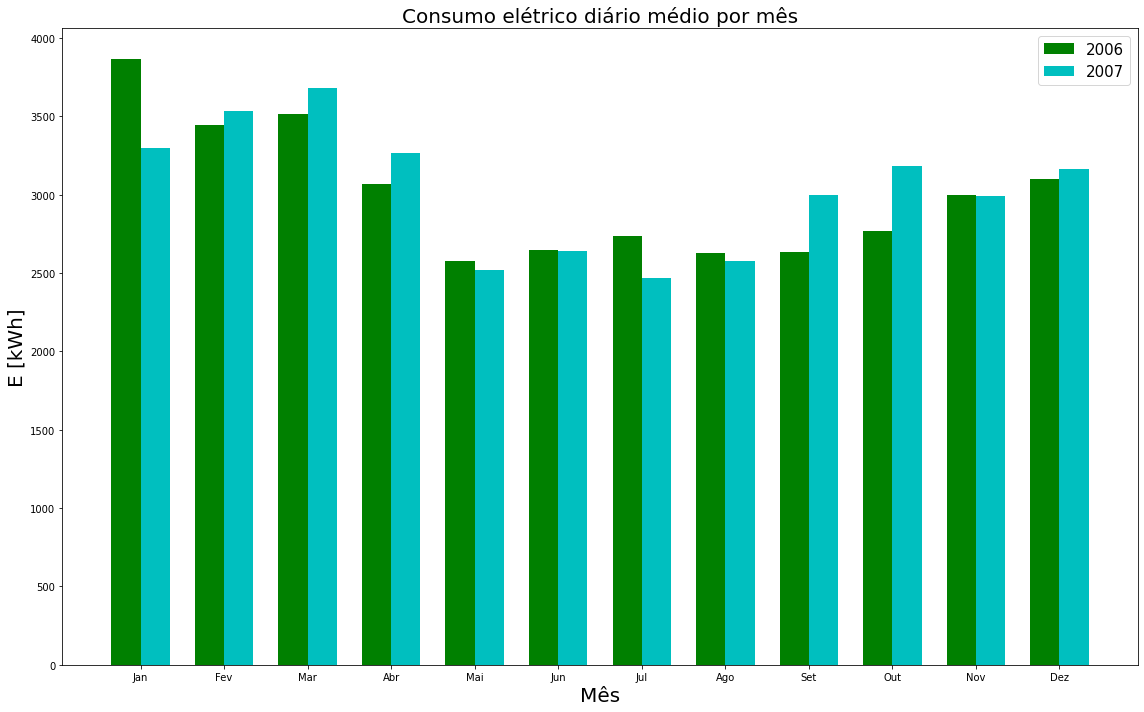

In [100]:
months = ['Jan','Fev','Mar','Abr','Mai','Jun', 'Jul', 'Ago','Set','Out','Nov','Dez']

monthly_avg_consumption_2006 = df_electric.loc['2006'].groupby(df_electric.loc['2006'].index.month).mean()
monthly_avg_consumption_2007 = df_electric.loc['2007'].groupby(df_electric.loc['2007'].index.month).mean()

ind = np.arange(12)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(16, 10))

# Plotting data
ax.bar(ind, monthly_avg_consumption_2006, width=width,color='g', label = '2006')
ax.bar(ind+width, monthly_avg_consumption_2007,width=width ,color='c', label='2007')

ax.set_xlabel("Mês",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Consumo elétrico diário médio por mês", fontsize=20)

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(months)

ax.legend(fontsize=15)
fig.tight_layout()

plt.show()


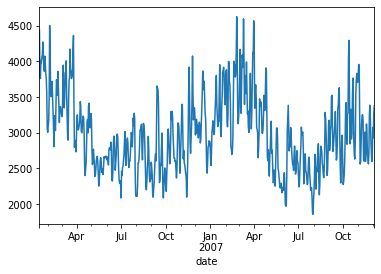

In [101]:
df_electric.plot()

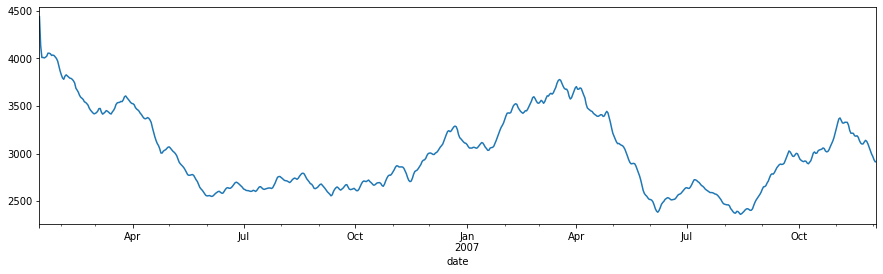

In [102]:
# Plotting a rolling avg of the electrical consumption

df_electric.rolling('30d').mean().plot(figsize=(15,4))

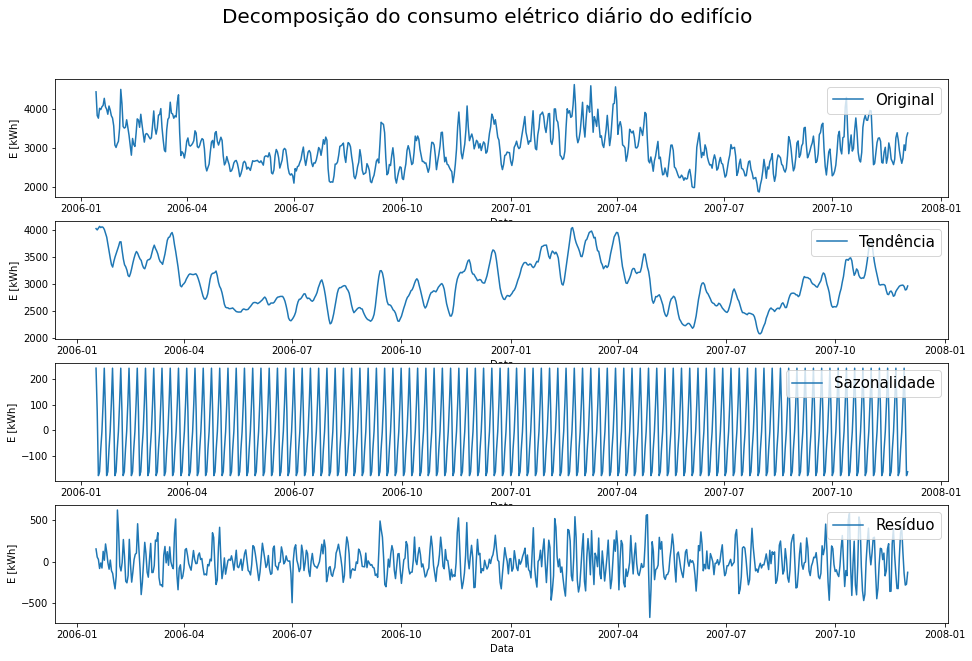

In [103]:
# Analisando o modelo estrutural do consumo
decomposition = seasonal_decompose(df_electric, model='additive')

# define componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Setting the plot
fig, axs = plt.subplots(4,1, figsize=(16,10))
fig.suptitle("Decomposição do consumo elétrico diário do edifício", fontsize=20)

axs[0].plot(df_electric, label='Original')
axs[0].set_xlabel("Data")
axs[0].set_ylabel("E [kWh]")
axs[0].legend(fontsize=15, loc='upper right')

axs[1].plot(trend, label='Tendência')
axs[1].set_xlabel("Data")
axs[1].set_ylabel("E [kWh]")
axs[1].legend(fontsize=15, loc='upper right')

axs[2].plot(seasonal, label='Sazonalidade')
axs[2].set_xlabel("Data")
axs[2].set_ylabel("E [kWh]")
axs[2].legend(fontsize=15, loc='upper right')

axs[3].plot(residual, label='Resíduo')
axs[3].set_xlabel("Data")
axs[3].set_ylabel("E [kWh]")
axs[3].legend(fontsize=15, loc='upper right')

ax.grid(True)
_ = plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 690 entries, 2006-01-14 to 2007-12-04
Freq: D
Empty DataFramedate
2006-01-14    ESE
2006-01-15     SE
2006-01-16    ENE
2006-01-17    ENE
2006-01-18     SE
Name: wind_dir, dtype: object


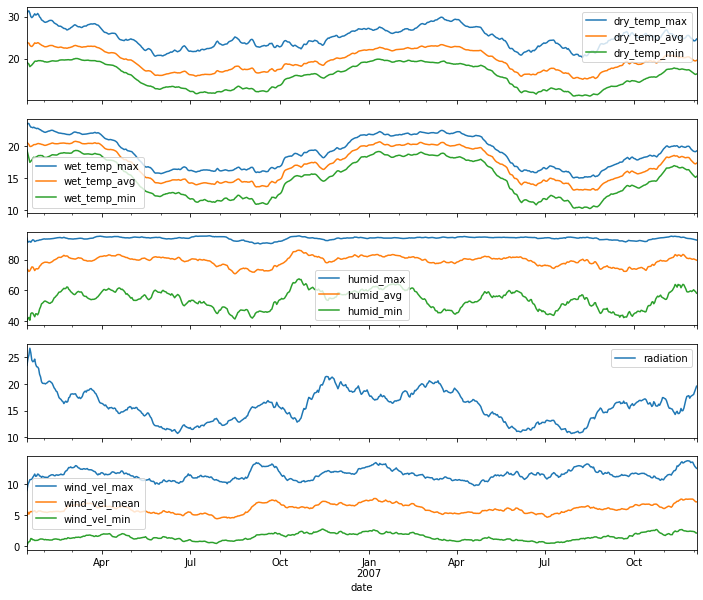

In [104]:
# Creating the features for the data

start_day = df_electric.index.min()
end_day = df_electric.index.max()

df_weather = pd.DataFrame(index=pd.date_range(start=start_day, end=end_day, freq="D", name='date'))
df_weather.info()

# Resampling our data into features of the model
# Dry bulb temperature
df_dry_temp = df_dry_temp_1h['dry_temp'].resample('D')
df_weather['dry_temp_max'] = df_dry_temp.agg(np.max)
df_weather['dry_temp_avg'] = df_dry_temp.agg(np.mean)
df_weather['dry_temp_min'] = df_dry_temp.agg(np.min)

# Wet bulb temperature
df_wet_temp = df_wet_temp_1h['wet_temp'].resample('D')

df_weather['wet_temp_max'] = df_wet_temp.agg(np.max)
df_weather['wet_temp_avg'] = df_wet_temp.agg(np.mean)
df_weather['wet_temp_min'] = df_wet_temp.agg(np.min)

# Humidity
df_humid = df_humid_1h['humidity'].resample('D')
df_weather['humid_max'] = df_humid.agg(np.max)
df_weather['humid_avg'] = df_humid.agg(np.mean)
df_weather['humid_min'] = df_humid.agg(np.min)


# Wind
df_wind = df_wind_1h.resample('D')
df_weather['wind_vel_max'] = df_wind['wind_vel'].agg(np.max)
df_weather['wind_vel_mean'] = df_wind['wind_vel'].agg(np.mean)
df_weather['wind_vel_min'] = df_wind['wind_vel'].agg(np.min)

df_weather['wind_dir'] = df_wind['wind_dir'].agg(lambda x:x.value_counts().index[0])

# Radiation (Already with 1d samples)
df_weather = df_weather.merge(df_rad_1d[['radiation']], how='left', on='date')

# Adding the most frequent wind direction of the day
print(df_weather['wind_dir'].head())
df_weather = pd.get_dummies(df_weather,
                            columns=['wind_dir'])

# Adding the day of the week as one-hot variables
df_weather = df_weather.join(pd.get_dummies(df_weather.index.day_name()).set_index(df_weather.index))

df_weather = df_weather.join(df_electric, how='left', on='date')

# Plotting the weather files
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,10), sharex=True)
df_weather[['dry_temp_max','dry_temp_avg', 'dry_temp_min']].rolling('30d').mean().plot(ax=axes[0])
df_weather[['wet_temp_max','wet_temp_avg', 'wet_temp_min']].rolling('30d').mean().plot(ax=axes[1])
df_weather[['humid_max','humid_avg', 'humid_min']].rolling('30d').mean().plot(ax=axes[2])
df_weather[['radiation']].rolling('30d').mean().plot(ax=axes[3])
df_weather[['wind_vel_max','wind_vel_mean','wind_vel_min']].rolling('30d').mean().plot(ax=axes[4])

In [105]:
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 690 entries, 2006-01-14 to 2007-12-04
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dry_temp_max   690 non-null    float64
 1   dry_temp_avg   690 non-null    float64
 2   dry_temp_min   690 non-null    float64
 3   wet_temp_max   690 non-null    float64
 4   wet_temp_avg   690 non-null    float64
 5   wet_temp_min   690 non-null    float64
 6   humid_max      690 non-null    int64  
 7   humid_avg      690 non-null    float64
 8   humid_min      690 non-null    int64  
 9   wind_vel_max   690 non-null    float64
 10  wind_vel_mean  690 non-null    float64
 11  wind_vel_min   690 non-null    float64
 12  radiation      690 non-null    float64
 13  wind_dir_E     690 non-null    uint8  
 14  wind_dir_ENE   690 non-null    uint8  
 15  wind_dir_ESE   690 non-null    uint8  
 16  wind_dir_N     690 non-null    uint8  
 17  wind_dir_NE    690 non-null    uint

Train set X (552, 36)
Train set y (552,)
Test set X (138, 36)
Test set y (138,)


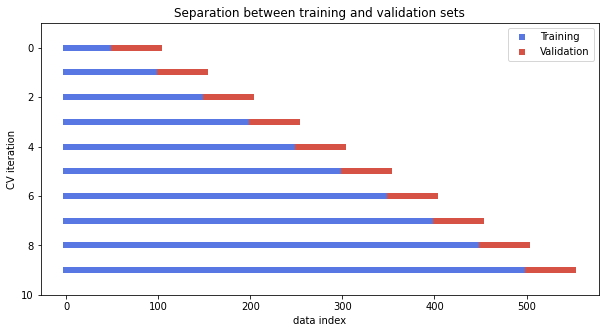

In [126]:
# separating the features from the target variable
X, y = df_weather.iloc[:, :-1], df_weather.iloc[:, -1]

X_training, X_test, y_training, y_test = train_test_split(X, y, 
                                                          test_size = 0.2, 
                                                          shuffle = False)

print("Train set X", X_training.shape)
print("Train set y", y_training.shape)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

# expanding window train-split method
# using all history to train

cv = TimeSeriesSplit(n_splits=10)

fig, ax = plt.subplots(figsize=(10, 5))
for index, (X_train, X_val) in enumerate(cv.split(X_training)):
    # Plota índices de treino e teste
    l1 = ax.scatter(X_train, [index] * len(X_train), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(X_val, [index] * len(X_val), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10, -1], title='Separation between training and validation sets', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

In [142]:
# define os valores possíveis para os parâmetros a serem testados
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=4)),
        ('clf', SVR(kernel = 'linear', C = 1))])

params = dict(reduce_dims__n_components=[10,15,20, 25],
                  clf__C=np.logspace(-3, 2, 5),
                  clf__gamma=np.logspace(-7, -4, 5),
                  clf__epsilon=[0.1,0.15,0.2,0.25,0.3],
                  clf__kernel=['linear', 'rbf','poly'],
                  )

# xgb_model = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
#                          reg_lambda=1,
#                          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                          objective = 'reg:squarederror',eval_metric='rmse',
#                          nthread=4, scale_pos_weight=1, seed=27)

# objeto para grid search com GridSearchCV
grid_search = GridSearchCV(pipe, 
                           param_grid = params, 
                           return_train_score = True,
                           n_jobs=4,
                           verbose=1,
                           scoring= 'r2',
                           cv = cv)

# treina modelo com Grid Search
grid_search.fit(X_training, y_training)

Fitting 10 folds for each of 1500 candidates, totalling 15000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 656 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 1656 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 3056 tasks      | elapsed:   40.0s
[Parallel(n_jobs=4)]: Done 4856 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 7056 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 9656 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 12656 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 14993 out of 15000 | elapsed:  3.5min remaining:    0.1s
[Parallel(n_jobs=4)]: Done 15000 out of 15000 | elapsed:  3.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reduce_dims',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=4, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        SVR(C=1, cache_size=200, coef0=0.0,
                                            d...
             param_grid={'clf__C': array([1.00000000e-03, 1.77827941e-02, 3.16227766



 Best hyperparameters: {'clf__C': 5.623413251903491, 'clf__epsilon': 0.2, 'clf__gamma': 1.778279410038923e-05, 'clf__kernel': 'linear', 'reduce_dims__n_components': 15}

 Best score: 0.3115021446546483
Average Score on Training set: 0.676 +/- 0.078
Average Score on Validation set: 0.312 +/- 0.212


<BarContainer object of 2 artists>

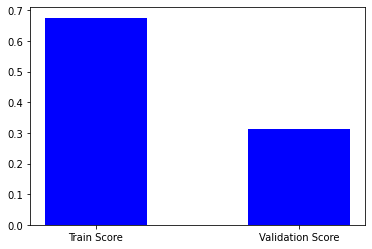

In [143]:
# resultados do cv
# imprime melhor combinação de hiperparâmetros
print()
print('\n Best hyperparameters:',grid_search.best_params_)
print('\n Best score:',grid_search.best_score_)

cv_results = pd.DataFrame(grid_search.cv_results_)

# print score médio nos sets de treino e teste
print("Average Score on Training set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                             cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# print score médio nos sets de validação
print("Average Score on Validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

scores = [cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
          cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0]]
labels = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(labels, scores, width, color="blue")

In [144]:
# seta melhor opção baseada nos hiperparâmetros
# utiliza as melhores opções de hiperparâmetros encontrados
model = grid_search.best_estimator_

# treina modelo com os melhores hiperparâmetros
model.fit(X_training, y_training)

# Randomforest {'max_depth': 10, 'max_features': 10, 'n_estimators': 100} 
#     Average Score on Training set: 0.920 +/- 0.021
#     Average Score on Validation set: 0.295 +/- 0.225

# RandomForest {'max_depth': 15, 'max_features': 5, 'n_estimators': 100} 
#     Average Score on Training set: 0.925 +/- 0.022
#     Average Score on Validation set: 0.274 +/- 0.217

# RandomForest {'max_depth': 20, 'max_features': 10, 'n_estimators': 300}
# Average Score on Training set: 0.931 +/- 0.020
# Average Score on Validation set: 0.304 +/- 0.222

# SVM Best hyperparameters: {'clf__C': 10.0, 'clf__epsilon': 0.2, 'clf__gamma': 3.981071705534969e-07, 'clf__kernel': 'linear', 'reduce_dims__n_components': 15}
# Average Score on Training set (RMSE): 282.431 +/- 15.212
# Average Score on Validation set (RMSE): 306.922 +/- 58.646


# Best hyperparameters: {'clf__C': 5.623413251903491, 'clf__epsilon': 0.2, 'clf__gamma': 1.778279410038923e-05, 'clf__kernel': 'linear', 'reduce_dims__n_components': 15}
# Average Score on Training set: 0.676 +/- 0.078
# Average Score on Validation set: 0.312 +/- 0.212
# RMSE train: 296.5257935024073
# RMSE test: 270.13697113235565

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reduce_dims',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVR(C=5.623413251903491, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.2, gamma=1.778279410038923e-05, kernel='linear',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [157]:
y_prediction = model.predict(X_test)

y_prediction = pd.Series(y_prediction, index=X_test.index)

print("MAE train:", mean_absolute_error(y_training, model.predict(X_training)))
print("MAE test:", mean_absolute_error(y_test, y_prediction))
print()
print("RMSE train:", np.sqrt(mean_squared_error(y_training, model.predict(X_training))) )
print("RMSE test:", np.sqrt(mean_squared_error(y_test, y_prediction)) )
print()
print("R2 train:", r2_score(y_training, model.predict(X_training)))
print("R2 test:", r2_score(y_test, y_prediction))

MAE train: 224.3785473773601
MAE test: 210.95228764681022

RMSE train: 296.5257935024073
RMSE test: 270.13697113235565

R2 train: 0.6965701439672878
R2 test: 0.6687086535725169


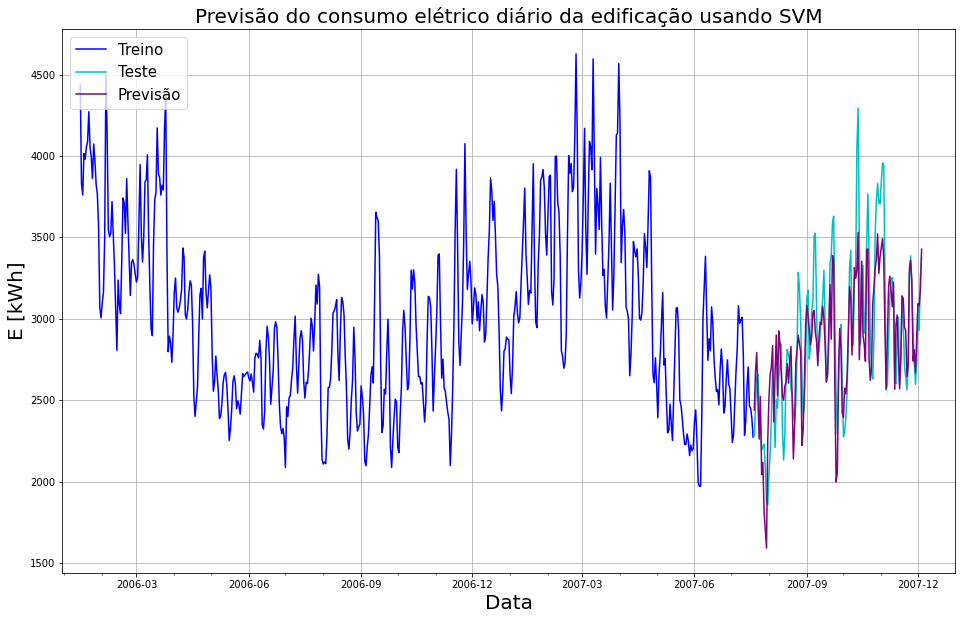

In [156]:
# PLotting the prediction values

# Setting the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Major ticks every 3 months.
fmt_3_months = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_3_months)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set x limits to nearest months.
datemin = start_date - timedelta(days=start_date.day + 1)
datemax = end_date + timedelta(days=31 - end_date.day)
ax.set_xlim(datemin, datemax)

# Plotting data
ax.plot(y_training.index, y_training, color='blue', label='Treino')
ax.plot(y_test.index, y_test, color='c', label='Teste')
ax.plot(y_prediction.index, y_prediction, color='purple', label='Previsão')


ax.set_xlabel("Data",fontsize=20)
ax.set_ylabel("E [kWh]",fontsize=20)
ax.set_title("Previsão do consumo elétrico diário da edificação usando SVM", fontsize=20)

ax.legend(fontsize=15, loc='upper left')
ax.grid(True)
plt.show()

In [ ]:
f